In [3]:
#!pip install pymc
#!pip install arviz
#!pip install openpyxl

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
from scipy.optimize import fmin
import openpyxl

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Przykład z wykładu

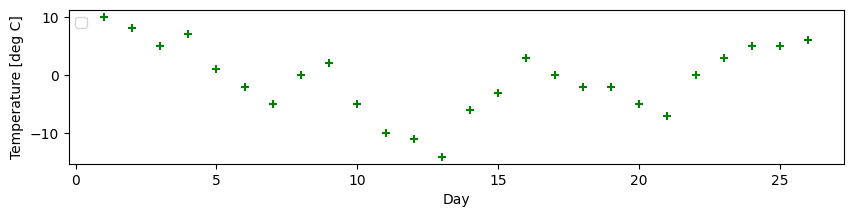

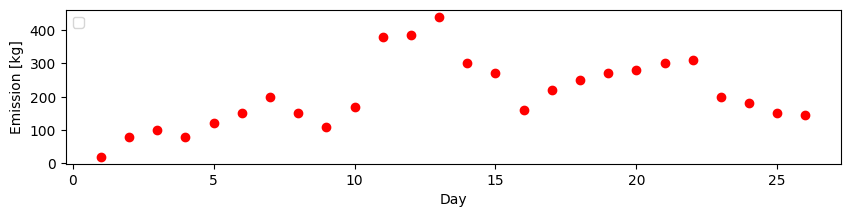

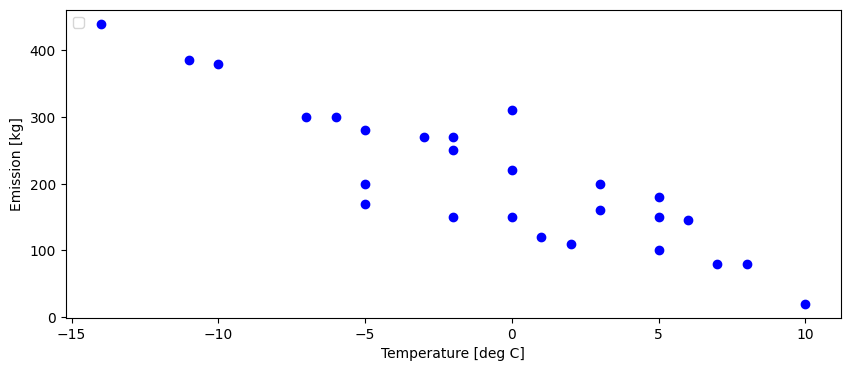

In [5]:
temperatures = [10, 8, 5, 7, 1, -2, -5, 0, 2, -5, -10, -11, -14, -6, -3, 3, 0, -2, -2, -5, -7, 0, 3, 5, 5, 6]
emissions = [20, 80, 100, 80, 120, 150, 200, 150, 110, 170, 380, 385, 440, 300, 270, 160, 220, 250, 270, 280,
          300, 310, 200, 180, 150, 145]
x_day = np.arange(1, 27, 1)

plt.figure(figsize=(10, 2))
plt.scatter(x_day, temperatures, color = 'green',marker = "+", alpha=1) #Dane empiryczne
plt.xlabel('Day')
plt.ylabel('Temperature [deg C]')
plt.legend(loc='upper left')

plt.show()

plt.figure(figsize=(10, 2))
plt.scatter(x_day, emissions, color = 'red',marker = "o", alpha=1) #Dane empiryczne
plt.xlabel('Day')
plt.ylabel('Emission [kg]')
plt.legend(loc='upper left')

plt.show()


plt.figure(figsize=(10, 4))
plt.scatter(temperatures, emissions, color = 'blue',marker = "o", alpha=1) #Dane empiryczne
plt.xlabel('Temperature [deg C]')
plt.ylabel('Emission [kg]')
plt.legend(loc='upper left')

plt.show()


Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


array([<Axes: title={'center': 'sigma_e'}>,
       <Axes: title={'center': 'b_1'}>, <Axes: title={'center': 'b_2'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

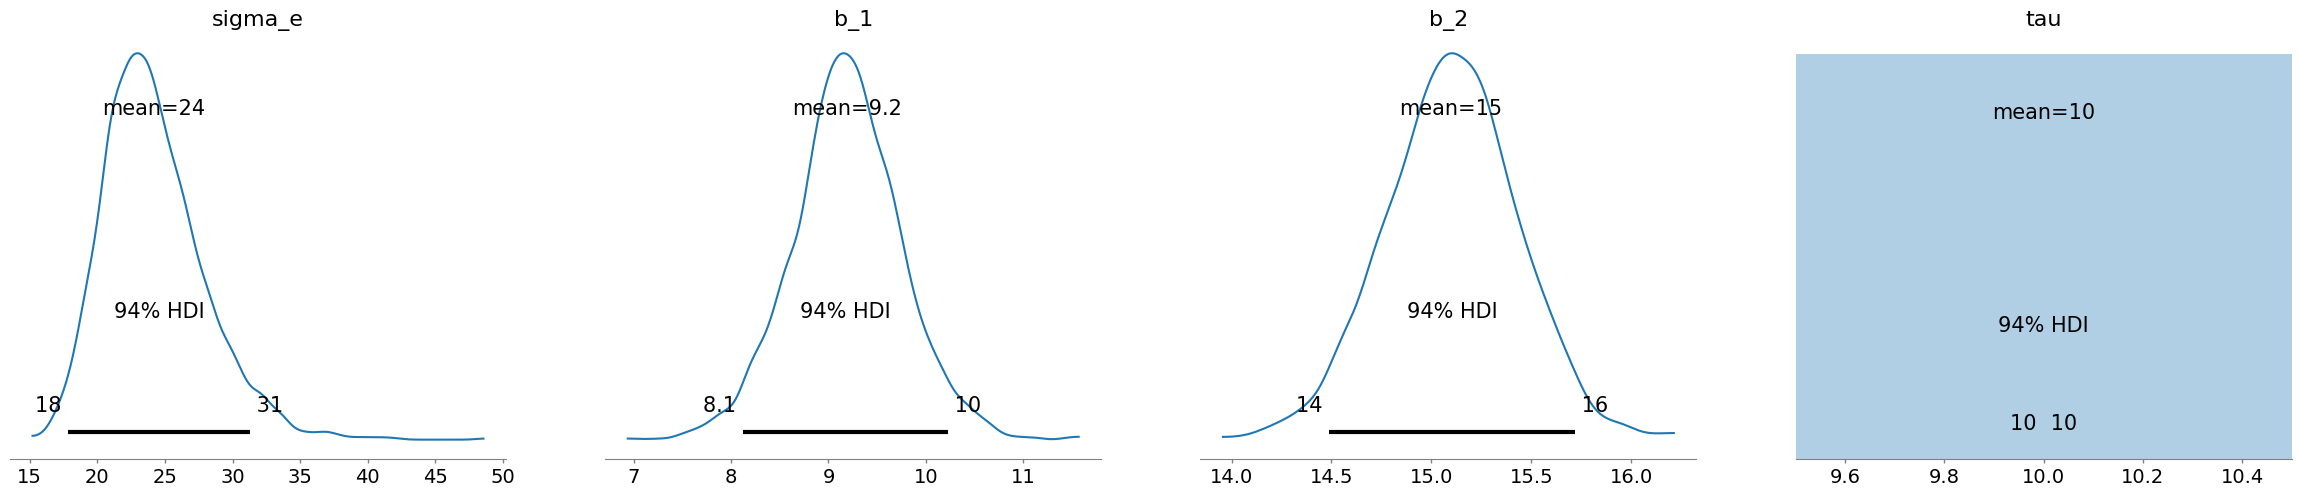

In [6]:
with pm.Model() as model:
    # Parametry modelu:
    # b_1 i b_2 to współczynniki liniowej zależności emisji od temperatury
    b_1 = pm.Uniform("b_1", lower=0, upper=20)  # Rozkład przed punktem zmiany
    b_2 = pm.Uniform("b_2", lower=0, upper=20)  # Rozkład po punkcie zmiany

    # Punkt zmiany (dzień, w którym zmienia się zależność między emisją a temperaturą)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(temperatures) - 1)

    # Tworzenie indeksów dla dni
    idx = np.arange(len(temperatures))

    # Określenie zależności emisji od temperatury w zależności od punktu zmiany
    # Jeśli dzień jest przed tau, stosujemy b_1, w przeciwnym wypadku b_2
    b = pm.math.switch(tau > idx, b_1, b_2)

    # Model teoretyczny emisji
    # Emisja zwiększa się liniowo wraz ze spadkiem temperatury poniżej 15°C
    m_e = pm.Deterministic("m_e", b * 15 - b * temperatures)

    # Odchylenie standardowe błędu emisji
    sigma_e = pm.Uniform("sigma_e", lower=0.1, upper=100)

    # Rozkład normalny opisujący obserwowane emisje z uwzględnieniem szumu
    emission = pm.Normal("emission", mu=m_e, sigma=sigma_e, observed=emissions)

    # Estymacja rozkładów posteriori za pomocą MCMC
    idata = pm.sample(2000, tune=2500)

az.plot_posterior(idata, var_names =["sigma_e", "b_1", "b_2", "tau"])

In [7]:
az.summary(idata,  var_names =["sigma_e", "b_1", "b_2", "tau"])

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_e,24.161,3.727,17.797,31.325,0.066,0.050,3619.0,2729.0,1.0
b_1,9.186,0.558,8.119,10.231,0.008,0.006,4569.0,2877.0,1.0
b_2,15.098,0.332,14.488,15.719,0.005,0.004,4046.0,2808.0,1.0
tau,10.000,0.000,10.000,10.000,0.000,0.000,4000.0,4000.0,NaN


### Wymyślony przykład - temperatura i sprzedaż zimnych napojów

Jako pracownik pewnej lokalnej firmy zajmujesz się nadzorowaniem sprzedaży zimnych napojów. Twoje raporty są wykorzystywane przez dział sprzedaży do planowania cen produktów na kolejny sezon. Firma rozpoczyna sprzedaż zimnych napojów gdy temperatura wzrasta powyżej 25 stopni. Lata analizy wyników firmy pokazały, że sprzedaż zimnych napojów poniżej tej temperatury jest nieopłacalna. Wiadomym jest, że sprzedaż wzrasta liniowo wraz ze wzrostem temperatury po przekroczeniu 25 stopni. 

Masz dostęp do danych o temperaturze i wartościach sprzedaży dla 100 dni. Chociaż ciepła pogoda naturalnie sprzyjała większemu zainteresowaniu napojami, twój zespół zauważył, że w badanym okresie odnotowano wyższe wartości sprzedaży niż przewidywano. Dowiedziałeś się również, że w tym okresie miało miejsce pewne wydarzenie - do miejscowości przyjechała duża grupa turystów z Europy Północnej. Ponieważ nie jest pewne czy w kolejnym sezonie takie wydarzenie będzie miało miejsce musisz uwzględnić to wydarzenie w swoim raporcie. Dział sprzedaży musi otrzymać odpowiednie dane dla dwóch okresów, przed przybyciem turystów i po ich przyjeździe. Z tego powodu musisz ustalić kiedy miał miejsce przyjazd turystów.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#Ziarno dla powtarzalności wyników
np.random.seed(1234)

#Liczba dni symulacji
num_days = 100

#Generowanie temperatur (temperatura od 25 do 35°C)
temperatures = np.random.uniform(25, 35, 100)

#Punkt zmiany fazy (właściwy dzień przyjazdu turystów)
tau_true = 60

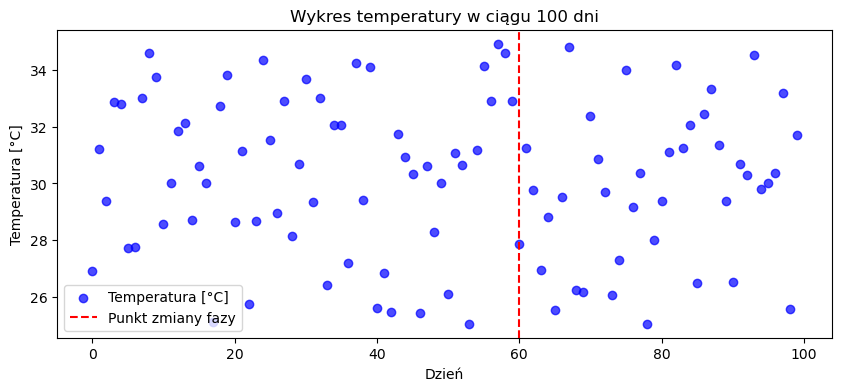

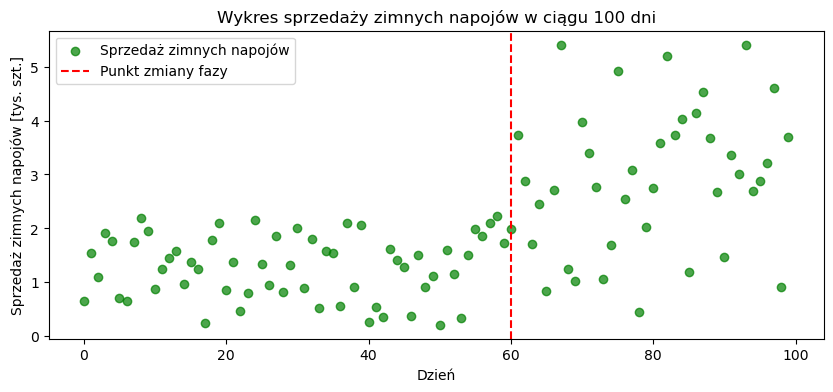

In [3]:
#Wolumen sprzedaży zimnych napojów [tys. szt.]
b_1_true = 0.2  #Wolumen sprzedaży w pierwszej fazie
b_2_true = 0.5 #Wolumen sprzedaży w drugiej fazie

#Wartości sprzedaży zimnych napojów
def gen_sales(temperatures, b_1, b_2, tau, day):
    if day < tau:
        return b_1 * max(0, temperatures[day] - 24)
    else:
        return b_2 * max(0, temperatures[day] - 24)

sales = np.array([gen_sales(temperatures, b_1_true, b_2_true, tau_true, day) for day in range(num_days)])

#Dodajemy szum do danych o wzroście
sigma_sales = 0.1  #Odchylenie standardowe
sales += np.random.normal(0, sigma_sales, size=100)

#Wykres temperatury w ciągu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), temperatures, color='blue', alpha=0.7, label='Temperatura [°C]')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzień')
plt.ylabel('Temperatura [°C]')
plt.title('Wykres temperatury w ciągu 100 dni')
plt.legend()
plt.show()

#Wykres sprzedaży zimnych napojów w ciągu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), sales, color='green', alpha=0.7, label='Sprzedaż zimnych napojów')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzień')
plt.ylabel('Sprzedaż zimnych napojów [tys. szt.]')
plt.title('Wykres sprzedaży zimnych napojów w ciągu 100 dni')
plt.legend()
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_early, b_late, sigma_sales]
>Metropolis: [tau]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 401 seconds.
d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


array([<Axes: title={'center': 'sigma_sales'}>,
       <Axes: title={'center': 'b_early'}>,
       <Axes: title={'center': 'b_late'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

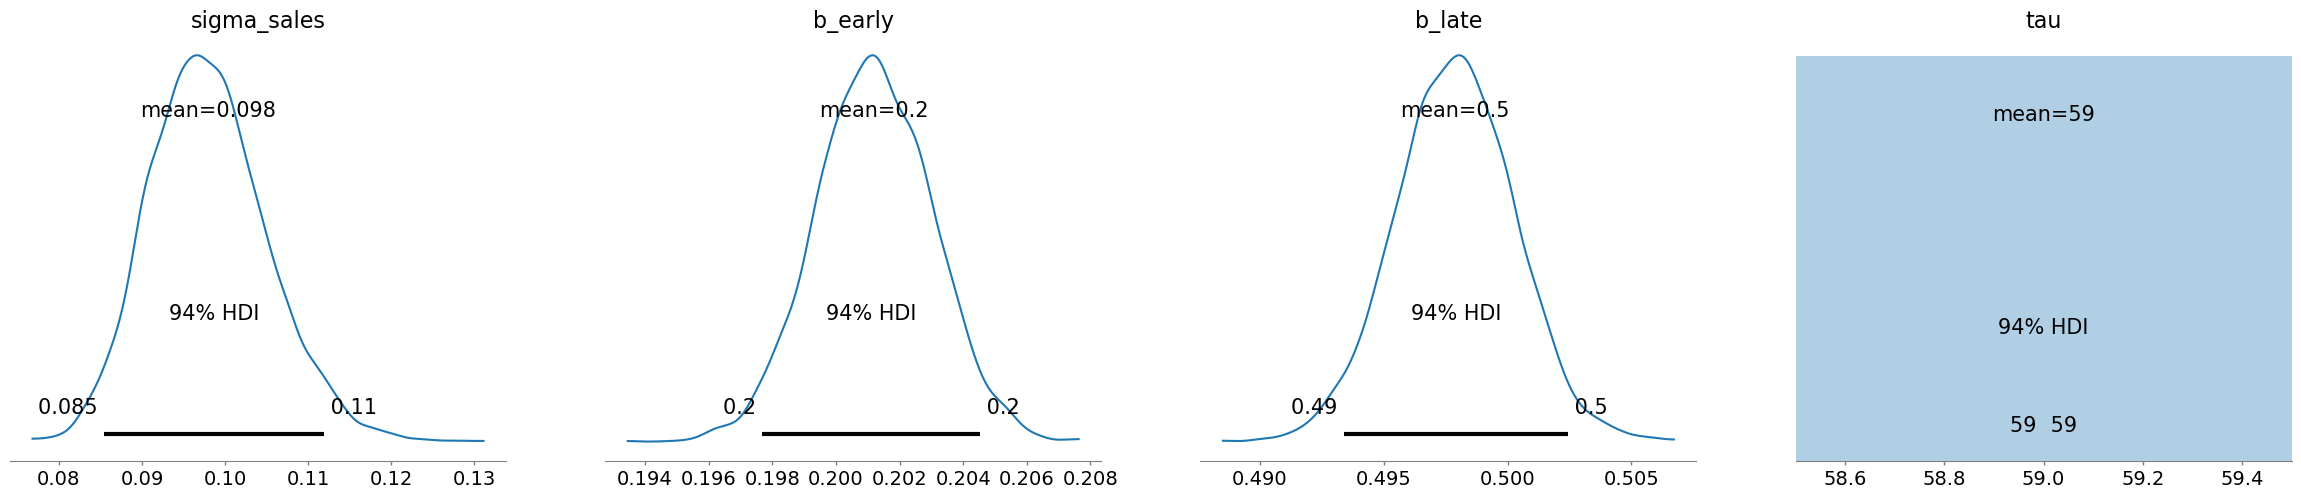

In [4]:
with pm.Model() as model:
    # Parametry modelu
    b_early = pm.Uniform("b_early", lower = 0, upper = 1)  # Współczynnik dla dni przed 60
    b_late = pm.Uniform("b_late", lower = 0, upper = 1)  # Współczynnik dla dni po 60

    # Punkt zmiany (dzień, w którym zmienia się zależność między sprzedażą a temperaturą)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(temperatures) - 1)

    # Tworzenie indeksów dla dni
    idx = np.arange(len(temperatures))

    # Określenie zależności sprzedaży od temperatury w zależności od punktu zmiany
    # Zmiana zależności sprzedaży w zależności od punktu zmiany
    b = pm.math.switch(tau < idx, b_late, b_early)

    # Modele teoretyczny sprzedaży
    # Sprzedaż zwiększa się liniowo wraz ze wzrostem temperatury powyżej 25°C
    # Zmienna deterministyczna, liniowo zależna od różnicy między stałą 25 a wartościami w wektorze temperatur
    m_sales = pm.Deterministic("m_sales", b * pm.math.maximum(0, temperatures - 24))
    # m_sales = b * (temperatures - 25)
    # tzn. wraz ze wzrostem temperatury rośnie sprzedaż zimnych napojów

    # Odchylenie standardowe (błąd w pomiarze sprzedaży)
    sigma_sales = pm.Uniform("sigma_sales", lower=0, upper=10)

    # Rozkład normalny dla obserwowanych danych sprzedaży
    sales_data = pm.Normal("sales_data", mu=m_sales, sigma=sigma_sales, observed=sales)

    # Estymacja rozkładów posteriori za pomocą MCMC
    idata = pm.sample(2000, tune=2500)

az.plot_posterior(idata, var_names =["sigma_sales", "b_early", "b_late", "tau"])

In [6]:
az.summary(idata,  var_names =["sigma_sales", "b_early", "b_late", "tau"])

d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_sales,0.098,0.007,0.085,0.112,0.0,0.0,11452.0,6048.0,1.0
b_early,0.201,0.002,0.198,0.205,0.0,0.0,12946.0,6036.0,1.0
b_late,0.498,0.002,0.493,0.502,0.0,0.0,11037.0,6380.0,1.0
tau,59.000,0.000,59.000,59.000,0.0,0.0,8000.0,8000.0,NaN



sigma_sales:

Średnia: 0.098
Przedział HDI 94%: [0.085, 0.112]
Model całkiem dobrze uchwycił szum (rzeczywisty 0.1)

𝑏_early:

Średnia: 0.201
Przedział HDI 94%: [0.198, 0.205]
Wolumen sprzedaż w pierwszej fazie został oszacowany bardzo dobrze (rzeczywisty 0.2).

𝑏_late

Średnia: 0.498
Przedział HDI 94%: [0.493, 0.502]
Wolumen sprzedaż w drugiej fazie został oszacowany dość bardzo dobrze (rzeczywisty 0.5).

tau (punkt zmiany fazy):

Średnia i HDI: 59
Model dobrze zidentyfikował dzień przejścia między dwiema fazami (rzeczywisty 60), co świadczy o skuteczności w wykrywaniu strukturalnych zmian w danych.

### Mniejsza różnica pomiędzy współczynnikami b

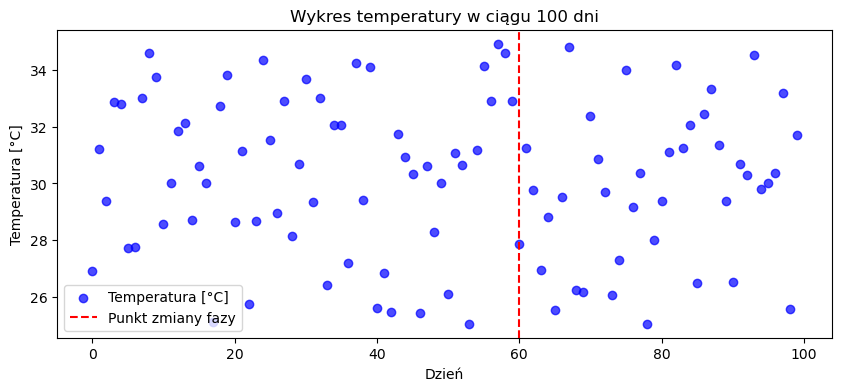

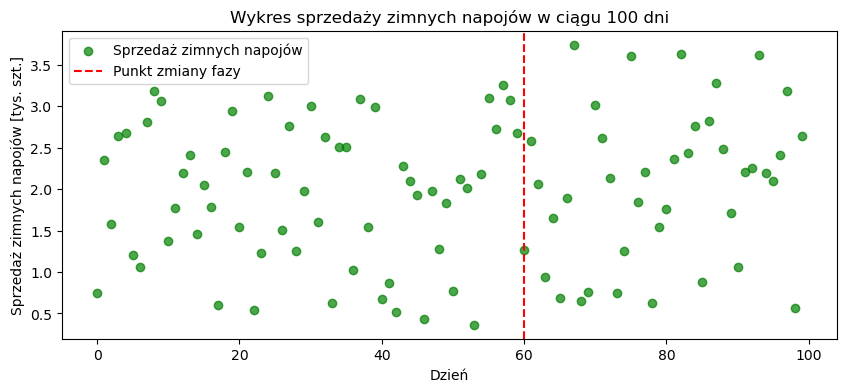

In [10]:
#Wolumen sprzedaży zimnych napojów [tys. szt.]
b_1_true = 0.3  #Wolumen sprzedaży w pierwszej fazie
b_2_true = 0.35 #Wolumen sprzedaży w drugiej fazie

#Wartości sprzedaży zimnych napojów
def gen_sales(temperatures, b_1, b_2, tau, day):
    if day < tau:
        return b_1 * max(0, temperatures[day] - 24)
    else:
        return b_2 * max(0, temperatures[day] - 24)

sales = np.array([gen_sales(temperatures, b_1_true, b_2_true, tau_true, day) for day in range(num_days)])

#Dodajemy szum do danych o wzroście
sigma_sales = 0.1  #Odchylenie standardowe
sales += np.random.normal(0, sigma_sales, size=100)

#Wykres temperatury w ciągu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), temperatures, color='blue', alpha=0.7, label='Temperatura [°C]')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzień')
plt.ylabel('Temperatura [°C]')
plt.title('Wykres temperatury w ciągu 100 dni')
plt.legend()
plt.show()

#Wykres sprzedaży zimnych napojów w ciągu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), sales, color='green', alpha=0.7, label='Sprzedaż zimnych napojów')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzień')
plt.ylabel('Sprzedaż zimnych napojów [tys. szt.]')
plt.title('Wykres sprzedaży zimnych napojów w ciągu 100 dni')
plt.legend()
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_early, b_late, sigma_sales]
>Metropolis: [tau]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 403 seconds.


array([<Axes: title={'center': 'sigma_sales'}>,
       <Axes: title={'center': 'b_early'}>,
       <Axes: title={'center': 'b_late'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

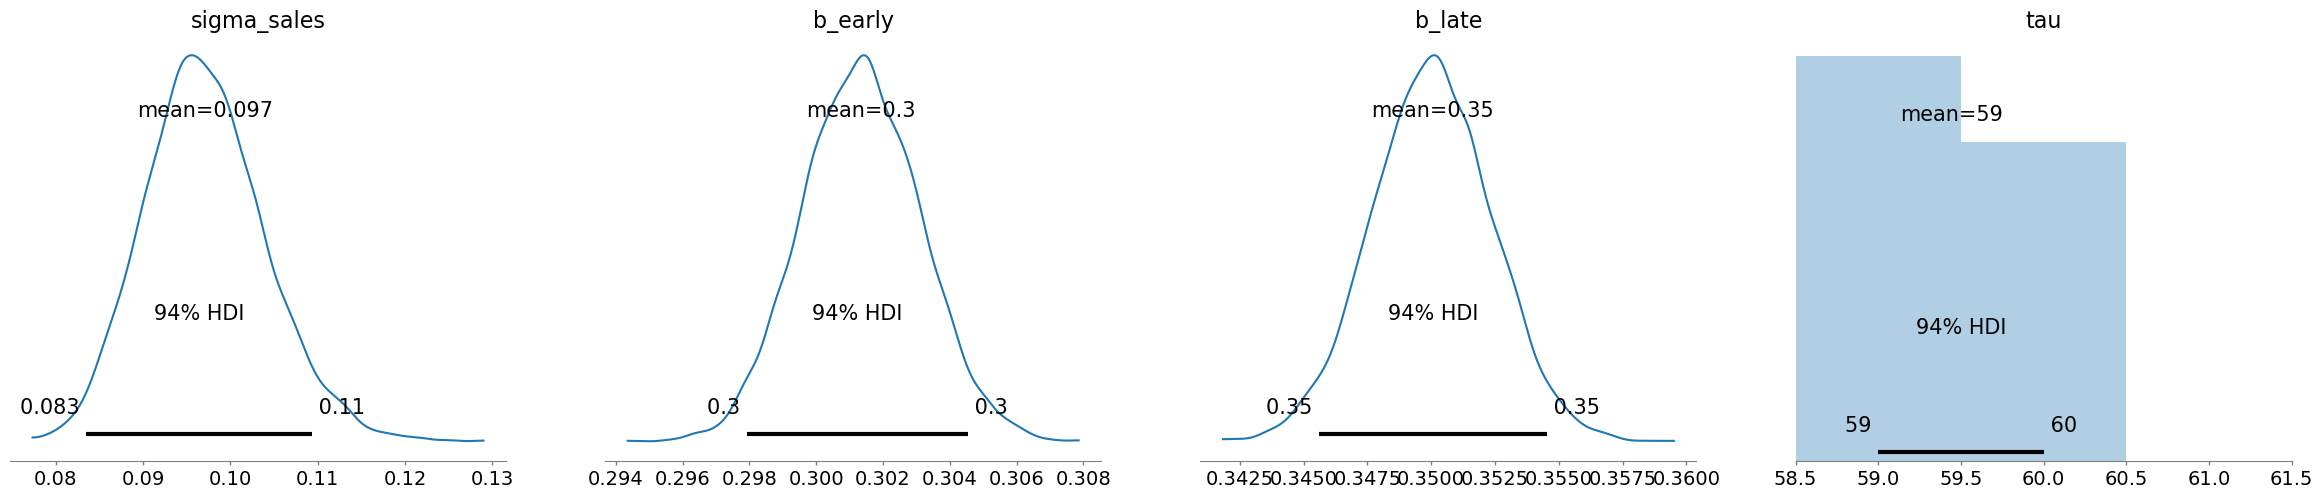

In [11]:
with pm.Model() as model:
    # Parametry modelu
    b_early = pm.Uniform("b_early", lower = 0, upper = 1)  # Współczynnik dla dni przed 60
    b_late = pm.Uniform("b_late", lower = 0, upper = 1)  # Współczynnik dla dni po 60

    # Punkt zmiany (dzień, w którym zmienia się zależność między sprzedażą a temperaturą)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(temperatures) - 1)

    # Tworzenie indeksów dla dni
    idx = np.arange(len(temperatures))

    # Określenie zależności sprzedaży od temperatury w zależności od punktu zmiany
    # Zmiana zależności sprzedaży w zależności od punktu zmiany
    b = pm.math.switch(tau < idx, b_late, b_early)

    # Modele teoretyczny sprzedaży
    # Sprzedaż zwiększa się liniowo wraz ze wzrostem temperatury powyżej 25°C
    # Zmienna deterministyczna, liniowo zależna od różnicy między stałą 25 a wartościami w wektorze temperatur
    m_sales = pm.Deterministic("m_sales", b * pm.math.maximum(0, temperatures - 24))
    # m_sales = b * (temperatures - 25)
    # tzn. wraz ze wzrostem temperatury rośnie sprzedaż zimnych napojów

    # Odchylenie standardowe (błąd w pomiarze sprzedaży)
    sigma_sales = pm.Uniform("sigma_sales", lower=0, upper=10)

    # Rozkład normalny dla obserwowanych danych sprzedaży
    sales_data = pm.Normal("sales_data", mu=m_sales, sigma=sigma_sales, observed=sales)

    # Estymacja rozkładów posteriori za pomocą MCMC
    idata = pm.sample(2000, tune=2500)

az.plot_posterior(idata, var_names =["sigma_sales", "b_early", "b_late", "tau"])

In [12]:
az.summary(idata,  var_names =["sigma_sales", "b_early", "b_late", "tau"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_sales,0.097,0.007,0.083,0.109,0.000,0.000,10181.0,5897.0,1.0
b_early,0.301,0.002,0.298,0.305,0.000,0.000,10656.0,5754.0,1.0
b_late,0.350,0.002,0.346,0.355,0.000,0.000,11623.0,6027.0,1.0
tau,59.441,0.497,59.000,60.000,0.011,0.008,1955.0,1951.0,1.0


sigma_sales:

Średnia: 0.097
Przedział HDI 94%: [0.083, 0.109]
Model całkiem dobrze uchwycił szum (rzeczywisty 0.1)

𝑏_early:

Średnia: 0.301
Przedział HDI 94%: [0.298, 0.305]
Wolumen sprzedaż w pierwszej fazie został oszacowany bardzo dobrze (rzeczywisty 0.3).

𝑏_late

Średnia: 0.350
Przedział HDI 94%: [0.346, 0.355]
Wolumen sprzedaż w drugiej fazie został oszacowany dość bardzo dobrze (rzeczywisty 0.35).

tau (punkt zmiany fazy):

Średnia i HDI: 59.44 [59.000, 60.000]
Model bardzo dobrze zidentyfikował dzień przejścia między dwiema fazami (rzeczywisty 60), co świadczy o skuteczności w wykrywaniu strukturalnych zmian w danych.

### Większy szum

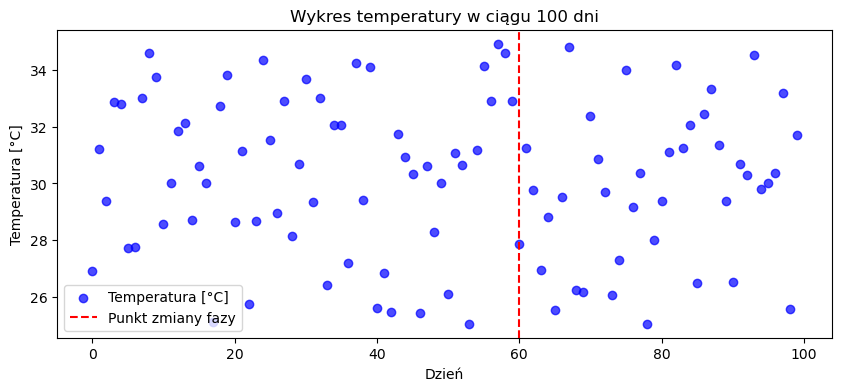

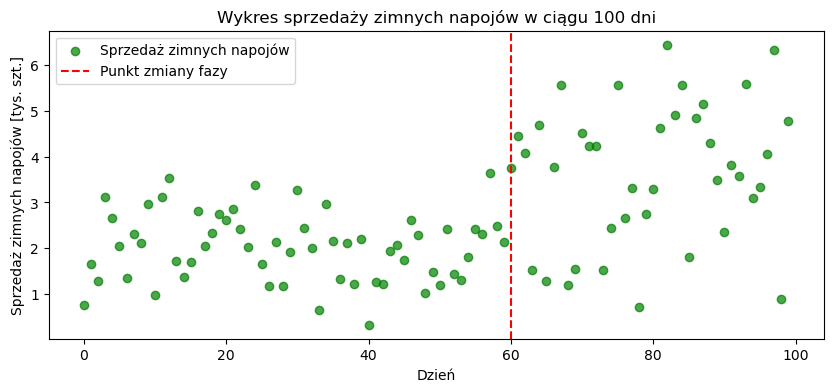

In [22]:
#Wolumen sprzedaży zimnych napojów [tys. szt.]
b_1_true = 0.2  #Wolumen sprzedaży w pierwszej fazie
b_2_true = 0.5 #Wolumen sprzedaży w drugiej fazie

#Wartości sprzedaży zimnych napojów
def gen_sales(temperatures, b_1, b_2, tau, day):
    if day < tau:
        return b_1 * max(0, temperatures[day] - 24)
    else:
        return b_2 * max(0, temperatures[day] - 24)

sales = np.array([gen_sales(temperatures, b_1_true, b_2_true, tau_true, day) for day in range(num_days)])

#Dodajemy szum do danych o wzroście
sigma_sales = 0.9  #Odchylenie standardowe
sales += abs(np.random.normal(0, sigma_sales, size=100))

#Wykres temperatury w ciągu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), temperatures, color='blue', alpha=0.7, label='Temperatura [°C]')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzień')
plt.ylabel('Temperatura [°C]')
plt.title('Wykres temperatury w ciągu 100 dni')
plt.legend()
plt.show()

#Wykres sprzedaży zimnych napojów w ciągu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), sales, color='green', alpha=0.7, label='Sprzedaż zimnych napojów')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzień')
plt.ylabel('Sprzedaż zimnych napojów [tys. szt.]')
plt.title('Wykres sprzedaży zimnych napojów w ciągu 100 dni')
plt.legend()
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_early, b_late, sigma_sales]
>Metropolis: [tau]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 374 seconds.


array([<Axes: title={'center': 'sigma_sales'}>,
       <Axes: title={'center': 'b_early'}>,
       <Axes: title={'center': 'b_late'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

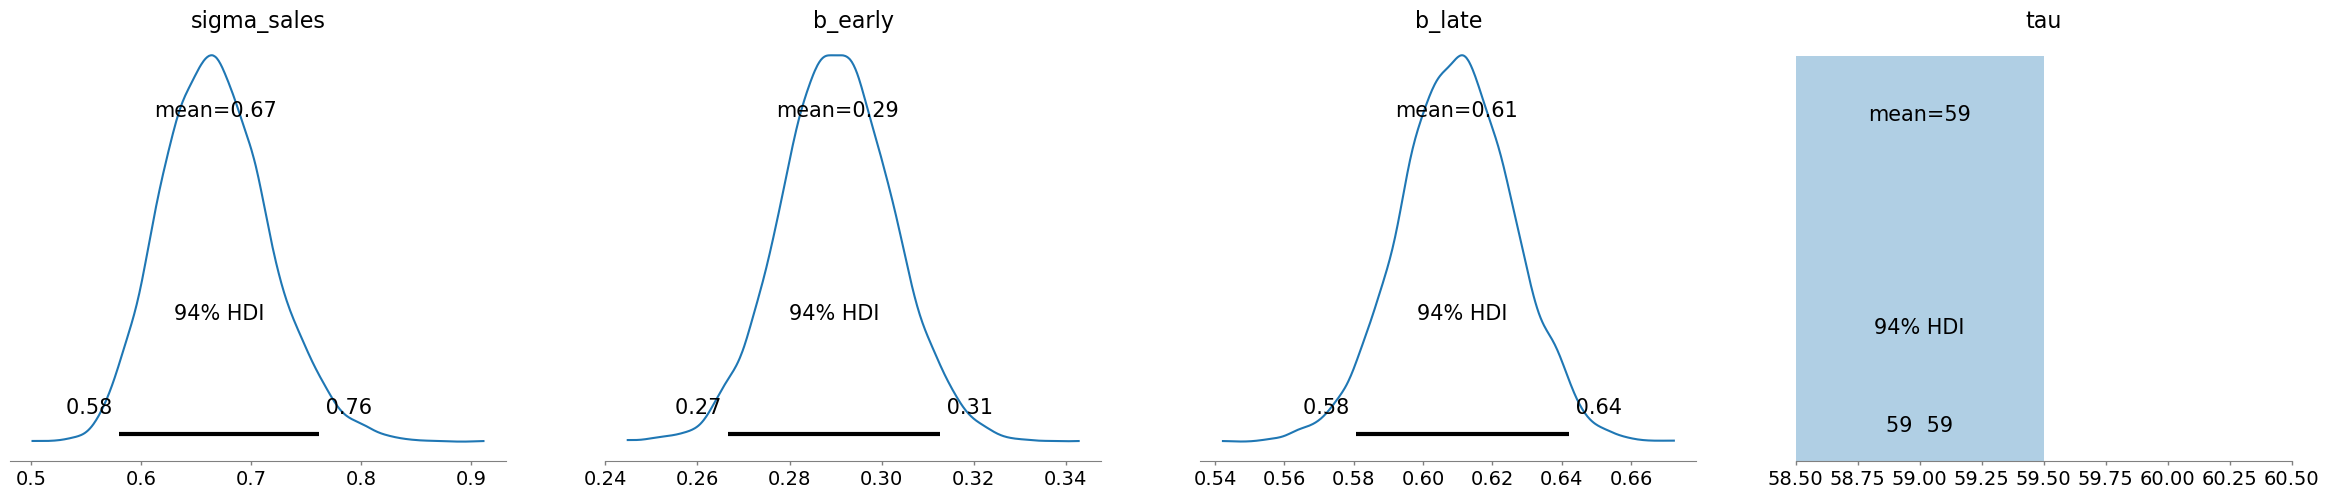

In [23]:
with pm.Model() as model:
    # Parametry modelu
    b_early = pm.Uniform("b_early", lower = 0, upper = 1)  # Współczynnik dla dni przed 60
    b_late = pm.Uniform("b_late", lower = 0, upper = 1)  # Współczynnik dla dni po 60

    # Punkt zmiany (dzień, w którym zmienia się zależność między sprzedażą a temperaturą)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(temperatures) - 1)

    # Tworzenie indeksów dla dni
    idx = np.arange(len(temperatures))

    # Określenie zależności sprzedaży od temperatury w zależności od punktu zmiany
    # Zmiana zależności sprzedaży w zależności od punktu zmiany
    b = pm.math.switch(tau < idx, b_late, b_early)

    # Modele teoretyczny sprzedaży
    # Sprzedaż zwiększa się liniowo wraz ze wzrostem temperatury powyżej 25°C
    # Zmienna deterministyczna, liniowo zależna od różnicy między stałą 25 a wartościami w wektorze temperatur
    m_sales = pm.Deterministic("m_sales", b * pm.math.maximum(0, temperatures - 24))
    # m_sales = b * (temperatures - 25)
    # tzn. wraz ze wzrostem temperatury rośnie sprzedaż zimnych napojów

    # Odchylenie standardowe (błąd w pomiarze sprzedaży)
    sigma_sales = pm.Uniform("sigma_sales", lower=0, upper=10)

    # Rozkład normalny dla obserwowanych danych sprzedaży
    sales_data = pm.Normal("sales_data", mu=m_sales, sigma=sigma_sales, observed=sales)

    # Estymacja rozkładów posteriori za pomocą MCMC
    idata = pm.sample(2000, tune=2500)

az.plot_posterior(idata, var_names =["sigma_sales", "b_early", "b_late", "tau"])

In [24]:
az.summary(idata,  var_names =["sigma_sales", "b_early", "b_late", "tau"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_sales,0.668,0.049,0.581,0.762,0.000,0.000,10191.0,4961.0,1.0
b_early,0.290,0.012,0.267,0.313,0.000,0.000,11490.0,6027.0,1.0
b_late,0.610,0.016,0.581,0.642,0.000,0.000,11434.0,5853.0,1.0
tau,59.001,0.034,59.000,59.000,0.001,0.001,1762.0,1762.0,1.0


sigma_sales:

Średnia: 0.668
Przedział HDI 94%: [0.581, 0.762]
Model nie uchwycił szum w pełni dobrze (rzeczywisty 0.9)

𝑏_early:

Średnia: 0.29
Przedział HDI 94%: [0.267m 0.313]
Wolumen sprzedaż w pierwszej fazie został oszacowany na większy niż w rzeczywistości (rzeczywisty 0.2).

𝑏_late

Średnia: 0.61
Przedział HDI 94%: [0.581, 0.642]
Wolumen sprzedaż w drugiej fazie został oszacowany na większy niż w rzeczywistości (rzeczywisty 0.5).

tau (punkt zmiany fazy):

Średnia i HDI: 59
Model całkiem dobrze zidentyfikował dzień przejścia między dwiema fazami (rzeczywisty 60), co świadczy o skuteczności w wykrywaniu strukturalnych zmian w danych.

### Gładkie przejście pomiędzy fazami

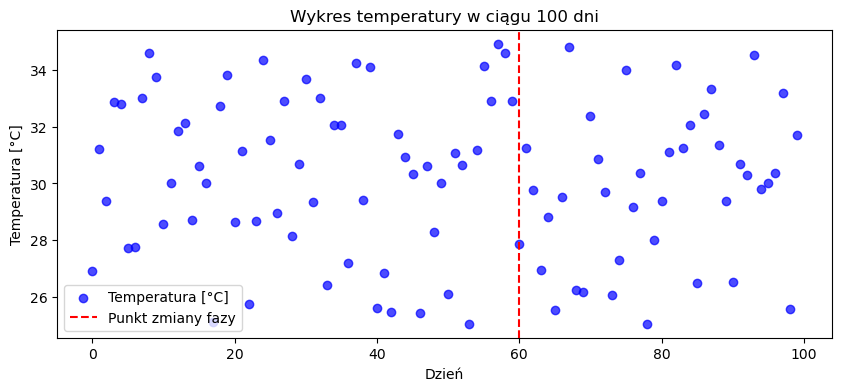

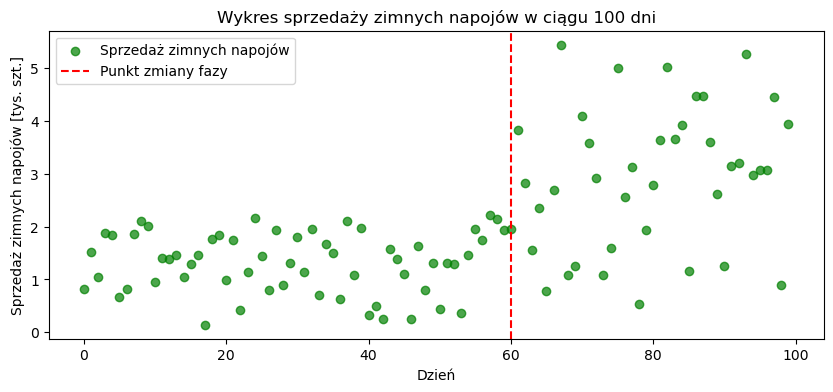

In [25]:
import numpy as np

# Wolumen sprzedaży zimnych napojów [tys. szt.]
b_1_true = 0.2  # Wolumen sprzedaży w pierwszej fazie
b_2_true = 0.5  # Wolumen sprzedaży w drugiej fazie


# Funkcja do generowania wartości b w zależności od dnia
def calculate_b(day, start_day, end_day, b_start, b_end):
    if day < start_day:
        return b_start
    elif day > end_day:
        return b_end
    else:
        # Interpolacja liniowa między b_start a b_end
        return b_start + (b_end - b_start) * (day - start_day) / (end_day - start_day)

# Wartości sprzedaży zimnych napojów
def gen_sales(temperatures, b_1, b_2, tau, day, start_day=40, end_day=60, b_start=0.2, b_end=0.5):
    if day < tau:
        return b_1 * max(0, temperatures[day] - 24)
    else:
        # Oblicz wartość b w zakresie dni od start_day do end_day
        b_dynamic = calculate_b(day, start_day, end_day, b_start, b_end)
        return b_dynamic * max(0, temperatures[day] - 24)

# Generowanie danych sprzedaży
sales = np.array([gen_sales(temperatures, b_1_true, b_2_true, tau_true, day) for day in range(num_days)])

#Dodajemy szum do danych o wzroście
sigma_sales = 0.1  #Odchylenie standardowe
sales += np.random.normal(0, sigma_sales, size=100)

#Wykres temperatury w ciągu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), temperatures, color='blue', alpha=0.7, label='Temperatura [°C]')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzień')
plt.ylabel('Temperatura [°C]')
plt.title('Wykres temperatury w ciągu 100 dni')
plt.legend()
plt.show()

#Wykres sprzedaży zimnych napojów w ciągu 100 dni
plt.figure(figsize=(10, 4))
plt.scatter(range(num_days), sales, color='green', alpha=0.7, label='Sprzedaż zimnych napojów')
plt.axvline(x=tau_true, color='red', linestyle='--', label='Punkt zmiany fazy')
plt.xlabel('Dzień')
plt.ylabel('Sprzedaż zimnych napojów [tys. szt.]')
plt.title('Wykres sprzedaży zimnych napojów w ciągu 100 dni')
plt.legend()
plt.show()
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_early, b_late, sigma_sales]
>Metropolis: [tau]


d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 392 seconds.
d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


array([<Axes: title={'center': 'sigma_sales'}>,
       <Axes: title={'center': 'b_early'}>,
       <Axes: title={'center': 'b_late'}>,
       <Axes: title={'center': 'tau'}>], dtype=object)

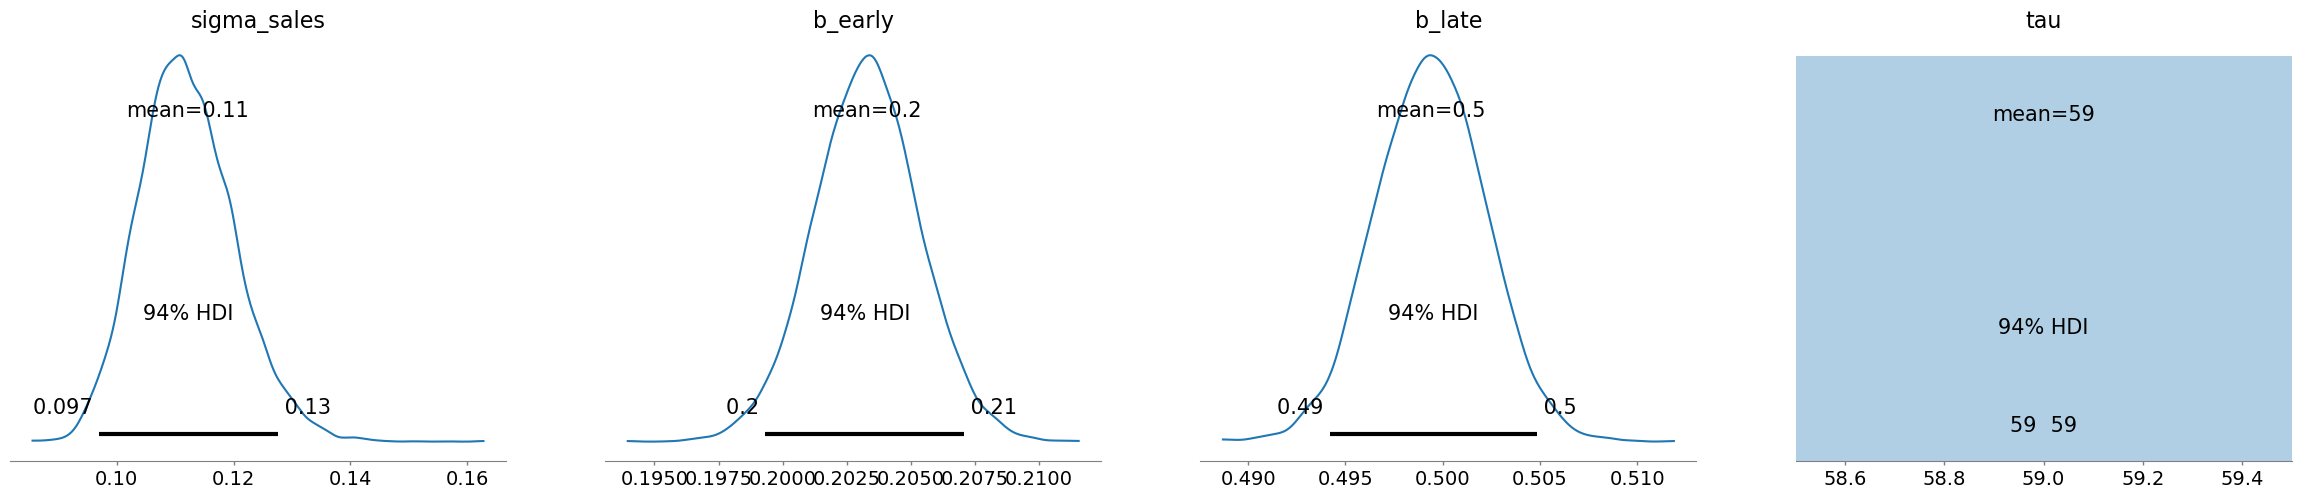

In [26]:
with pm.Model() as model:
    # Parametry modelu
    b_early = pm.Uniform("b_early", lower = 0, upper = 1)  # Współczynnik dla dni przed 60
    b_late = pm.Uniform("b_late", lower = 0, upper = 1)  # Współczynnik dla dni po 60

    # Punkt zmiany (dzień, w którym zmienia się zależność między sprzedażą a temperaturą)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(temperatures) - 1)

    # Tworzenie indeksów dla dni
    idx = np.arange(len(temperatures))

    # Określenie zależności sprzedaży od temperatury w zależności od punktu zmiany
    # Zmiana zależności sprzedaży w zależności od punktu zmiany
    b = pm.math.switch(tau < idx, b_late, b_early)

    # Modele teoretyczny sprzedaży
    # Sprzedaż zwiększa się liniowo wraz ze wzrostem temperatury powyżej 25°C
    # Zmienna deterministyczna, liniowo zależna od różnicy między stałą 25 a wartościami w wektorze temperatur
    m_sales = pm.Deterministic("m_sales", b * pm.math.maximum(0, temperatures - 24))
    # m_sales = b * (temperatures - 25)
    # tzn. wraz ze wzrostem temperatury rośnie sprzedaż zimnych napojów

    # Odchylenie standardowe (błąd w pomiarze sprzedaży)
    sigma_sales = pm.Uniform("sigma_sales", lower=0, upper=10)

    # Rozkład normalny dla obserwowanych danych sprzedaży
    sales_data = pm.Normal("sales_data", mu=m_sales, sigma=sigma_sales, observed=sales)

    # Estymacja rozkładów posteriori za pomocą MCMC
    idata = pm.sample(2000, tune=2500)

az.plot_posterior(idata, var_names =["sigma_sales", "b_early", "b_late", "tau"])

In [28]:
az.summary(idata,  var_names =["sigma_sales", "b_early", "b_late", "tau"])

d:\Programy\Anaconda\envs\python3.11.7\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_sales,0.112,0.008,0.097,0.128,0.0,0.0,10620.0,5846.0,1.0
b_early,0.203,0.002,0.199,0.207,0.0,0.0,11213.0,5537.0,1.0
b_late,0.499,0.003,0.494,0.505,0.0,0.0,11244.0,5840.0,1.0
tau,59.000,0.000,59.000,59.000,0.0,0.0,8000.0,8000.0,NaN


sigma_sales:

Średnia: 0.112
Przedział HDI 94%: [0.097	0.128]
Model uchwycił szum całkiem dobrze (rzeczywisty 0.1)

𝑏_early:

Średnia: 0.203
Przedział HDI 94%: [0.199, 0.207]
Wolumen sprzedaż w pierwszej fazie został oszacowany dobrze (rzeczywisty 0.2).

𝑏_late

Średnia: 0.499
Przedział HDI 94%: [0.494, 0.505]
Wolumen sprzedaż w drugiej fazie został oszacowany dobrze (rzeczywisty 0.5).

tau (punkt zmiany fazy):

Średnia i HDI: 59
Model całkiem dobrze zidentyfikował dzień przejścia między dwiema fazami (rzeczywisty 60), co świadczy o skuteczności w wykrywaniu strukturalnych zmian w danych.